In [25]:
# Libs to catch and treat data:
import tweepy           
import pandas as pd    
import numpy as np      
import collections
import re
from os import listdir, mkdir, utime
from os.path import isfile, join, exists
import os
from textblob import TextBlob

# Libs for plotting and visualization:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('seaborn')
%matplotlib inline

# getting access keys saved at credentials.py:
from credentials import *

In [5]:
# API Setup
def twitter_setup():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api

In [6]:
api = twitter_setup()
tweets = tweepy.models.ResultSet()
twitter_profile = '@who'

for i in range(6):
    tweets += api.user_timeline(screen_name=twitter_profile, count=200, page=i)
print(f'Tweets obtained: {len(tweets)}.')

#tweets = api.user_timeline(screen_name='@jairbolsonaro', count=200)

print('The first 5 tweets:')
for tweet in tweets[:5]:
    print(tweet.text)
    print()

Tweets obtained: 1200.
The first 5 tweets:
The full briefing on #COVID19 by @DrTedros 👇
https://t.co/NqhFrJJTbu

"Only together can we get through the #COVID19 pandemic. In national unity and global solidarity"-@DrTedros

"This new partnership is another great example of solidarity that builds on the solidarity flights, solidarity tria… https://t.co/CqUhjsJq8u

"#COVID19 has exposed the uneven distribution of life-saving medical equipment across the world.

Tomorrow, the Tec… https://t.co/iX4RbfPKZS

"Even relatively short-term interruptions to treatment pose a significant threat to a person’s health and potential… https://t.co/dvVEda2jLw



In [7]:
df = pd.DataFrame(data=[tweet.text for tweet in tweets], columns=['Tweets'])
display(df.head())

,Tweets
0,The full briefing on #COVID19 by @DrTedros 👇\n...
1,"""Only together can we get through the #COVID19..."
2,"""This new partnership is another great example..."
3,"""#COVID19 has exposed the uneven distribution ..."
4,"""Even relatively short-term interruptions to t..."


### Let's take a look at the internal methods and variables available.

In [8]:
print(dir(tweets[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_api', '_json', 'author', 'contributors', 'coordinates', 'created_at', 'destroy', 'entities', 'favorite', 'favorite_count', 'favorited', 'geo', 'id', 'id_str', 'in_reply_to_screen_name', 'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'parse', 'parse_list', 'place', 'possibly_sensitive', 'retweet', 'retweet_count', 'retweeted', 'retweets', 'source', 'source_url', 'text', 'truncated', 'user']


### From here we can select some relevant variables like: id, created_at, source, favorite_count, retweet_count

In [9]:
print(tweets[0].place)

None


In [10]:
df['Size'] = np.array([len(tweet.text) for tweet in tweets])
df['Id'] = np.array([tweet.id for tweet in tweets])
df['Created at'] = np.array([tweet.created_at for tweet in tweets])
df['Source'] = np.array([tweet.source for tweet in tweets])
df['Likes'] = np.array([tweet.favorite_count for tweet in tweets])
df['Retweets'] = np.array([tweet.retweet_count for tweet in tweets])

In [11]:
df.head(15)

,Tweets,Size,Id,Created at,Source,Likes,Retweets
0,The full briefing on #COVID19 by @DrTedros 👇\n...,68,1259877909013069824,2020-05-11 16:07:55,Twitter Web App,49,18
1,"""Only together can we get through the #COVID19...",107,1259875866710073344,2020-05-11 15:59:48,Twitter Web App,98,34
2,"""This new partnership is another great example...",140,1259875865586020352,2020-05-11 15:59:48,Twitter Web App,38,11
3,"""#COVID19 has exposed the uneven distribution ...",140,1259875864428318722,2020-05-11 15:59:48,Twitter Web App,8,4
4,"""Even relatively short-term interruptions to t...",140,1259875578494279680,2020-05-11 15:58:39,Twitter Web App,18,4
5,"""Despite attention being focused on the #COVID...",140,1259875575931469837,2020-05-11 15:58:39,Twitter Web App,35,9
6,"""This could effectively set the ⏰ back by more...",140,1259875324709437441,2020-05-11 15:57:39,Twitter Web App,21,8
7,"""The group’s worst case scenario, a 6-month di...",140,1259875323354718209,2020-05-11 15:57:39,Twitter Web App,23,10
8,"""Today saw the release of new modeling on #HIV...",140,1259874720155160578,2020-05-11 15:55:15,Twitter Web App,34,15
9,"""Workplaces should develop action plans for pr...",144,1259874331523518464,2020-05-11 15:53:42,Twitter Web App,57,22


### Now let's analyze some statistics and basic information like mean size of tweets, tweets with more likes and tweets with more retweets.

In [12]:
mean_size = np.mean(df['Size'])

most_liked = np.max(df['Likes'])
most_retweeted = np.max(df['Retweets'])

most_liked_index = df[df.Likes == most_liked].index[0]
most_retweeted_index = df[df.Retweets == most_retweeted].index[0]


print(f'Tweet with more Likes:\n{df["Tweets"][most_liked_index]}')
print(f'Qtd. Likes: {most_liked}')
print(f'Qtd. Characters: {df["Size"][most_liked_index]}\n')

print(f'Tweet with more Retweets:\n{df["Tweets"][most_retweeted_index]}')
print(f'Qtd. Likes: {most_retweeted}')
print(f'Qtd. Characters: {df["Size"][most_retweeted_index]}')

Tweet with more Likes:
It's #WorldImmunizationWeek!
Vaccine-preventable diseases include:
Cervical cancer
Cholera
Diphtheria
Ebola
Hep B
I… https://t.co/EnjhJo4ZaJ
Qtd. Likes: 20408
Qtd. Characters: 140

Tweet with more Retweets:
It's #WorldImmunizationWeek!
Vaccine-preventable diseases include:
Cervical cancer
Cholera
Diphtheria
Ebola
Hep B
I… https://t.co/EnjhJo4ZaJ
Qtd. Likes: 9684
Qtd. Characters: 140


### Let's take a look at the time series in relation to the size of tweets, likes and retweets.

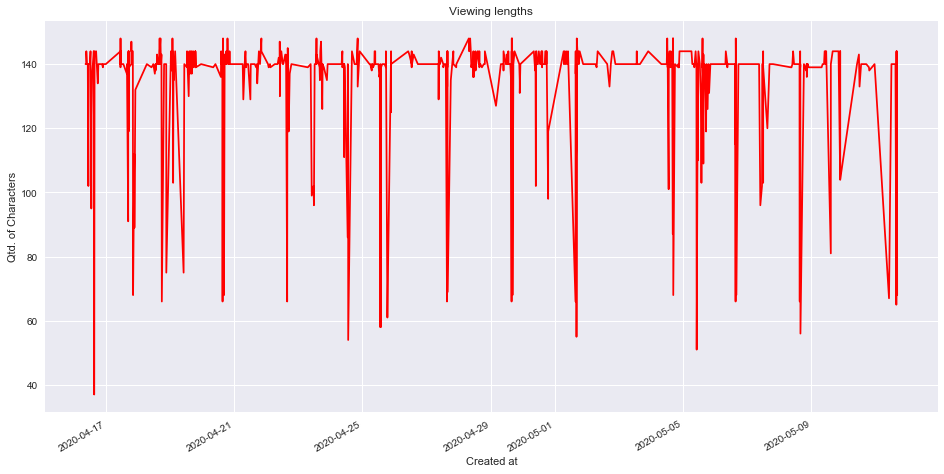

In [13]:
ts_size = pd.Series(data=df['Size'].values, index=df['Created at'])
ts_likes = pd.Series(data=df['Likes'].values, index=df['Created at'])
ts_retweets = pd.Series(data=df['Retweets'].values, index=df['Created at'])

fig = plt.figure(figsize=(16, 8))
ts_size.plot(color='r')
plt.xlabel('Created at')
plt.ylabel('Qtd. of Characters')
plt.title('Viewing lengths')
fig.savefig('img\char_view.png')
plt.show()

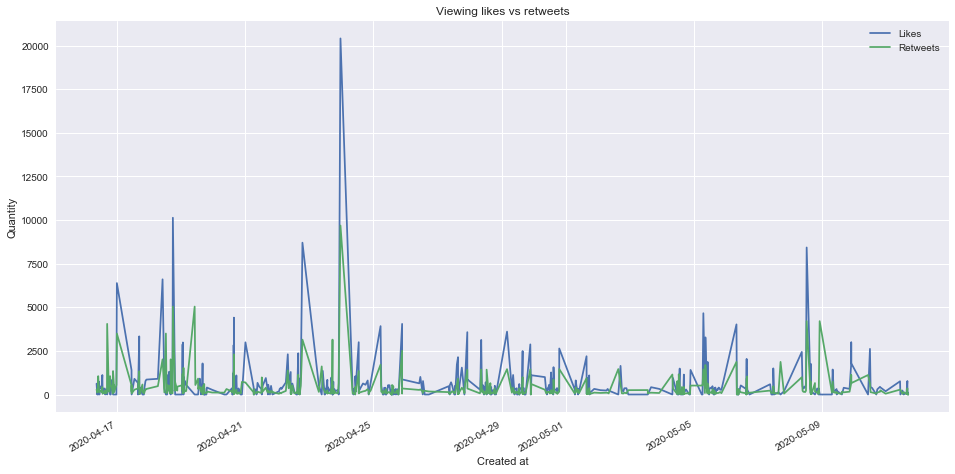

In [14]:
fig = plt.figure(figsize=(16, 8))
ts_likes.plot(label="Likes", legend=True)
ts_retweets.plot(label="Retweets", legend=True);
plt.xlabel('Created at')
plt.ylabel('Quantity')
plt.title('Viewing likes vs retweets')
fig.savefig('img\likes_re_view.png')
plt.show()

### Now let's take a look at the types of sources of tweets.

In [15]:
#  Get possible sources:
sources = []
for source in df['Source']:
    if source not in sources:
        sources.append(source)

# Print sources:
print("Content creation sources:")
for source in sources:
    print(f'* {source}')

Content creation sources:
* Twitter Web App
* Periscope
* Twitter for iPhone
* Twitter Media Studio


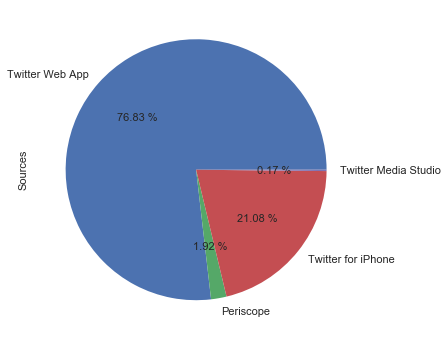

In [16]:
percent = np.zeros(len(sources))

for source in df['Source']:
    for index in range(len(sources)):
        if source == sources[index]:
            percent[index] += 1
            pass

percent /= 100

# Pie chart:
fig = plt.figure()
pie_chart = pd.Series(percent, index=sources, name='Sources')
pie_chart.plot.pie(fontsize=11, autopct='%.2f %%', figsize=(6, 6));
fig.savefig('img\sources_view.png')

### Let's vectorize and check the frequency of each word in the set of tweets we are analyzing.

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
count_matrix = cv.fit_transform(df.Tweets)
word_count = pd.DataFrame(cv.get_feature_names(), columns=["word"])
word_count["count"] = count_matrix.sum(axis=0).tolist()[0]
word_count = word_count.sort_values("count", ascending=False).reset_index(drop=True)
word_count[:50]

,word,count
0,the,1061
1,co,943
2,https,932
3,to,820
4,of,535
5,and,495
6,covid19,410
7,who,349
8,in,329
9,rt,311


### Let's add a few words to the set of Stopwords.

In [18]:
stopwords = set(STOPWORDS)
stopwords = stopwords.union(set(['https', 'co', 'rt', 'one', 're', 've', 'will', 'un', 'amp']))

wordcount = collections.defaultdict(int)
for word in stopwords:
    word_count = word_count[word_count.word != word]        

In [19]:
word_count[:60]

,word,count
6,covid19,410
15,drtedros,227
18,health,148
21,countries,113
24,world,96
36,global,75
37,response,75
39,day,69
42,today,65
43,support,64


### Creating a Word Cloud

<Figure size 1280x640 with 0 Axes>

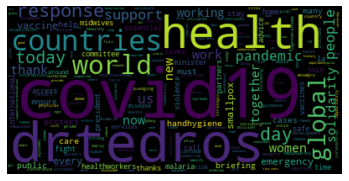

In [29]:
wordcount = collections.defaultdict(int)
wordcount = word_count.set_index('word')['count'].to_dict()
wc = WordCloud().generate_from_frequencies(wordcount)
plt.figure(figsize=(16, 8), dpi=80)
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
text = ''
for word in word_count['word']:
    text += word + ' '
    
    
# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()
globe_mask = np.array(Image.open("img/globe_mask.png"))
globe_mask = globe_mask[:,:,0]

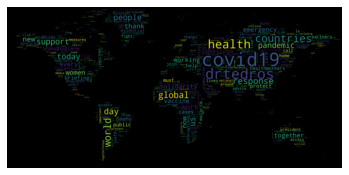

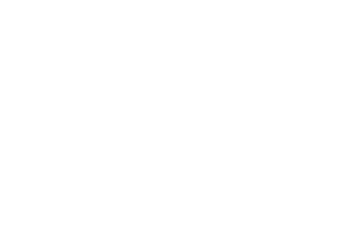

In [37]:
wc = WordCloud(background_color="black", max_words=2000, mask=globe_mask,
               stopwords=stopwords, contour_width=3, contour_color='black')

# generate word cloud
wc.generate_from_frequencies(wordcount)
# store to file
wc.to_file("img/brainstorm.png")

# show
#plt.figure(figsize=(25, 8), dpi=300)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.figure()
#plt.imshow(brazil_mask, cmap=plt.cm.gray, interpolation='bilinear')
plt.axis("off")
plt.show()

### Here we clear the tweets and perform sentiment analysis of each one.

In [32]:
def tweet_cleaner(tweet):
    '''
    Function to clean the text of a tweet by removing
    links and special characters using regex.
    '''
    #return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|(\w+:\/\/\S+)", " ", tweet).split())

    
def sentiment_analysis(tweet):
    '''
    Function to classify the sentiment of the tweet using textblob
    '''
    #print(tweet)
    print('')
    analysis = TextBlob(tweet_cleaner(tweet))
    
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [33]:
# Create an analysis results column:
df['Sentiment Rank'] = np.array([sentiment_analysis(tweet) for tweet in df['Tweets']])

In [34]:
df.head(10)

,Tweets,Size,Id,Created at,Source,Likes,Retweets,Sentiment Rank
0,The full briefing on #COVID19 by @DrTedros 👇\n...,68,1259877909013069824,2020-05-11 16:07:55,Twitter Web App,49,18,1
1,"""Only together can we get through the #COVID19...",107,1259875866710073344,2020-05-11 15:59:48,Twitter Web App,98,34,0
2,"""This new partnership is another great example...",140,1259875865586020352,2020-05-11 15:59:48,Twitter Web App,38,11,1
3,"""#COVID19 has exposed the uneven distribution ...",140,1259875864428318722,2020-05-11 15:59:48,Twitter Web App,8,4,-1
4,"""Even relatively short-term interruptions to t...",140,1259875578494279680,2020-05-11 15:58:39,Twitter Web App,18,4,1
5,"""Despite attention being focused on the #COVID...",140,1259875575931469837,2020-05-11 15:58:39,Twitter Web App,35,9,0
6,"""This could effectively set the ⏰ back by more...",140,1259875324709437441,2020-05-11 15:57:39,Twitter Web App,21,8,1
7,"""The group’s worst case scenario, a 6-month di...",140,1259875323354718209,2020-05-11 15:57:39,Twitter Web App,23,10,-1
8,"""Today saw the release of new modeling on #HIV...",140,1259874720155160578,2020-05-11 15:55:15,Twitter Web App,34,15,1
9,"""Workplaces should develop action plans for pr...",144,1259874331523518464,2020-05-11 15:53:42,Twitter Web App,57,22,1


In [35]:
tweets_positive = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment Rank'][index] > 0]
tweets_neutral   = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment Rank'][index] == 0]
tweets_negative = [ tweet for index, tweet in enumerate(df['Tweets']) if df['Sentiment Rank'][index] < 0]

## Results

In [36]:
print(f'Positive tweets: {len(tweets_positive)*100/len(df["Tweets"]):.2f}%')
print(f'Neutral tweets: {len(tweets_neutral)*100/len(df["Tweets"]):.2f}%')
print(f'Negative tweets: {len(tweets_negative)*100/len(df["Tweets"]):.2f}%')

Positive tweets: 43.42%
Neutral tweets: 45.00%
Negative tweets: 11.58%
